In [1]:
%matplotlib inline
import sys, os
import numpy as np
import cupy as cp 
from cupyx.time import repeat
import ot
import ot.gpu
from ot.datasets import make_1D_gauss as gauss
import matplotlib.pyplot as plt
from timeit import timeit
from time import time
import csv
%load_ext autoreload
%autoreload 2

# Generate data



In [2]:
def save(C, nrows, ncols, filename):
    assert C.flags['F_CONTIGUOUS']
    output_file = open(filename, 'wb')
    C.tofile(output_file)
    output_file.close()

def readfval(filename, dtype=np.float32):
    f = [];
    with open(filename) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            f.append(float(row[0]))
    return np.asarray(f, dtype=dtype)

def readoutput(filename):
    with open(filename) as csvfile:
        k = []; t = []; r = []; f = [];
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            k.append(int(row[0]))
            t.append(float(row[1]))
            r.append(float(row[2]))
            f.append(float(row[3]))
    return k, t, r, f

def two_dimensional_gaussian_ot(m, n, filename=None):
    d = 2
    mu_s = np.random.normal(0.0, 1.0, (d,)) # Gaussian mean
    A_s = np.random.rand(d, d)
    cov_s = np.dot(A_s, A_s.transpose()) # Gaussian covariance matrix
    mu_t = np.random.normal(5.0, 10.0, (d,))
    A_t = np.random.rand(d, d)
    cov_t = np.dot(A_t, A_t.transpose())
    xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s).astype(np.float32)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t).astype(np.float32)
    p, q = np.ones((m,)).astype(np.float32) / m, np.ones((n,)).astype(np.float32) / n  
    C = np.array(ot.dist(xs, xt)).astype(np.float32)
    C /= C.max()
    if filename is not None:
        save(np.array(C, order='F'), m, n, filename)
    return m, n, C, p, q

# Single Experiment

## Problem data

In [ ]:
m, n, C, p, q = two_dimensional_gaussian_ot(512, 512, "data/cmatrix")

In [ ]:
femd = ot.emd2(p, q, C, numItermax=2000000)  # LP solver

## Drot on the same matrix C

Text(0, 0.5, 'Primal Residual')

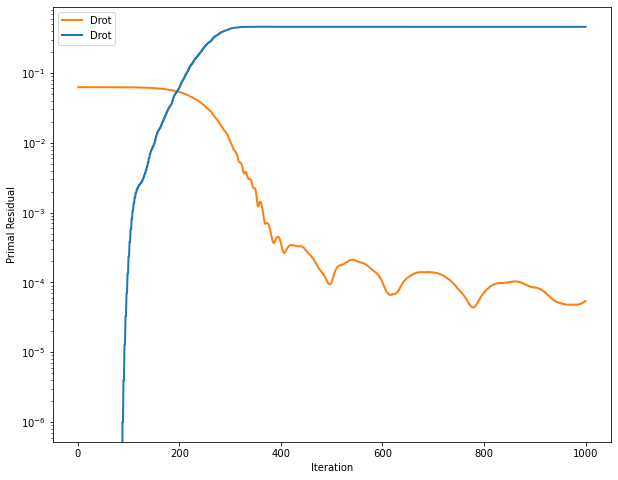

In [3]:
# Remember to run DROT before executing this cell

filenames = [ 'output/' + 'drot_512_0.001953.csv' ];
labels = ['Drot']
colors = ['C0', 'C1']
markers = ['', '']
fig1 = plt.figure(figsize=(10, 8))

optval = 0

for i in range(len(filenames)):
    k, t, r, f = readoutput(filenames[i])

    plt.plot(k, [res for res in r], color=colors[i+1], marker=markers[i], label=labels[i], linewidth=2)
    plt.plot(k, [abs(fval - optval) for fval in f], color=colors[i], marker=markers[i], label=labels[i], linewidth=2)

plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Primal Residual")

# Performance profile

In [5]:
def multi_experiment(m, n, max_iters, accuracies, skregs, alpha=1.0, ntests=20, verbskip=1):
    num_accuracies = accuracies.shape[0]
    num_algs = skregs.shape[0] + 1
    outs = np.zeros([num_algs, 1, num_accuracies, ntests])
    optvals = []
    if not os.path.isdir('data'):
            os.mkdir('data')
    
    for test_idx in range(ntests):
        print("\n *** Experiment", test_idx+1, "of", ntests, "***")
        
        filename = "data/cmatrix_" + str(m) + '_test_' + str(test_idx)
        m, n, C, p, q = two_dimensional_gaussian_ot(m, n, filename)
        assert(C.dtype==np.float32)

        optval = ot.emd2(p, q, C, numItermax=2_000_000)
        optvals.append(optval)
        
        skout = []                        
        for reg in skregs:
            skout.append(sinkhorn_knopp(p, q, C, reg, numItermax=1000, stopThr=1e-4))
        
        for sk_idx, xval in enumerate(skout):
            outs[sk_idx+1, 0, :, test_idx] = abs(np.sum(xval*C) - optvals[-1]) / optvals[-1]

    file_name = 'dims_' + str(m) + '_test_' + str(ntests)
    np.save('output/'+file_name + '.npy', outs)
    return file_name, optvals

def profile(dir, accuracies, optvals, labels, colors):         
    outs = np.load(dir)
    (num_algs, num_objs_computed, num_accuracies, ntests) = outs.shape
    performance_ratio = np.zeros((num_algs, num_accuracies))

#     Read DROT's data
    filename = 'output/drot_' + str(m) + '_ntests_' + str(ntests) + '.csv'
    fval = readfval(filename)
    for test_idx in range(ntests):
            outs[0, 0, :, test_idx] = abs(fval[test_idx] - optvals[test_idx]) / optvals[test_idx]
    
    for alg_idx in range(num_algs):
        for acc_idx in range(num_accuracies):
            performance_ratio[alg_idx, acc_idx] = np.sum((outs[alg_idx, 0, acc_idx, :] <= accuracies[acc_idx])) / ntests

    fig = plt.figure()        
    for alg_idx in range(num_algs):
        plt.plot(accuracies, performance_ratio[alg_idx, :], color=colors[alg_idx], label=labels[alg_idx], linewidth=2.5)
  
    ylabel = r'Performance ratio'
    plt.xlabel(r'Accuracy')
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.legend()
        
    return fig

In [ ]:
m, n = 512, 512
max_iters = 1000
accuracies = np.logspace(-4.5, -1, num=15)
skregs = np.array([1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])

file_name, optvals = multi_experiment(m, n, max_iters, accuracies, skregs, alpha=2, ntests=100)

In [ ]:
labels = ['DROT', 'SK1', 'SK2', 'SK3', 'SK4', 'Sk5', 'SK6']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
dir = "output/" + file_name  + '.npy'
fig = profile(dir, accuracies, optvals, labels, colors)

# fig.tight_layout()
# fig.savefig('figures/'+ file_name + '_mean_10_f32.eps', format='eps')

# Runtime performance

### Generate data for DROT and runtime for Sinkhorn

In [9]:
def gen_and_run(dims, ntests=10, eps=1e-14):
    times = np.zeros((len(dims), ntests))
    for idx, n in enumerate(dims):
        print("\n *** m = n =", n, "***")
        m, n, C, p, q = two_dimensional_gaussian_ot(n, n, "data/cmatrix_" + str(n))
        for test in range(ntests):
            _, log = sinkhorn_knopp(p, q, C, reg=5e-2, numItermax=100, stopThr=eps, log=True)
            times[idx, test] = log['time']

    if not os.path.isdir('output'):
        os.mkdir('output')
    np.save('output/sinkhorn_runtime.npy', times)
    return times

def loadruntime(dims, ntests=1):
    times = np.zeros((len(dims), ntests))
    for idx, n in enumerate(dims):
        for test in range(ntests):
            k, t, _, _ = readoutput('output/drot_runtime_' + str(n) + '_test_' + str(test) + '.csv')
            times[idx, test] = t[-1]
#         print(k[-1])
    return np.asarray(times)


### Run 

In [8]:
dims = [100, 200, 500, 1000, 2000, 5000, 10000, 20000]
sktimes = gen_and_run(dims, ntests=10, eps=1e-14)


 *** m = n = 100 ***
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100

 *** m = n = 200 ***
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100

 *** m = n = 500 ***
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100
Terminated at iteration 100

 *** m = n = 1000 ***
Terminated at iteration 100
Terminated at iteration 100
Terminated at i

Text(0, 0.5, 'Time [ms]')

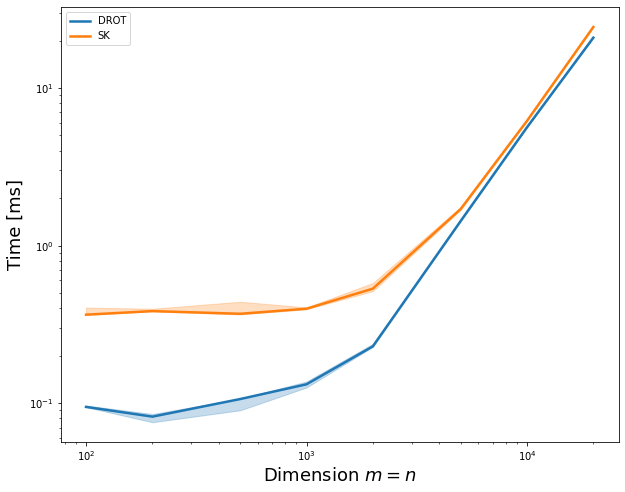

In [11]:
# Remember to run ./bin/runtime before executing this cell

dims = [100, 200, 500, 1000, 2000, 5000, 10000, 20000]
labels = ['DROT', 'SK']
colors = ['C0', 'C1']

times = loadruntime(dims, ntests=10) / 100
sktimes = np.load('output/sinkhorn_runtime.npy') * 1000 / 100

fig = plt.figure(figsize=(10, 8))
plt.plot(dims, np.median(times, axis=1), color=colors[0], label=labels[0], linewidth=2.5)
plt.plot(dims, np.median(sktimes, axis=1), color=colors[1], label=labels[1], linewidth=2.5)
plt.fill_between(dims, np.quantile(times, 0.95, axis=1), np.quantile(times, 0.05, axis=1), color=colors[0], alpha=.25)  
plt.fill_between(dims, np.quantile(sktimes, 0.95, axis=1), np.quantile(sktimes, 0.05, axis=1), color=colors[1], alpha=.25)  

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel(r'Dimension $m=n$', fontsize=18)
plt.ylabel("Time [ms]", fontsize=18)

# fig.tight_layout()
# fig.savefig('figures/runtime.eps', format='eps')

# Mics

In [7]:
def sinkhorn_knopp(a, b, M, reg, numItermax=1000, stopThr=1e-9,
                   verbose=False, log=False, to_numpy=True, **kwargs):
    a = cp.asarray(a)
    b = cp.asarray(b)
    M = cp.asarray(M)

    if len(a) == 0:
        a = cp.ones((M.shape[0],), dtype=M.dtype) / M.shape[0]
    if len(b) == 0:
        b = cp.ones((M.shape[1],), dtype=M.dtype) / M.shape[1]

    # init data
    Nini = len(a)
    Nfin = len(b)

    if log:
        log = {'err': [], 'time': []}

    start = time()

    u = cp.ones(Nini, dtype=M.dtype) / Nini
    v = cp.ones(Nfin, dtype=M.dtype) / Nfin

    K = cp.empty(M.shape, dtype=M.dtype)
    cp.divide(M, -reg, out=K)
    cp.exp(K, out=K)

    tmp1 = cp.empty(a.shape, dtype=M.dtype)
    tmp2 = cp.empty(b.shape, dtype=M.dtype)

    Kp = (1 / a).reshape(-1, 1) * K
     
    cpt = 0  # CPU
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = cp.dot(K.T, u)
        v = cp.divide(b, KtransposeU)
        u = 1. / cp.dot(Kp, v)

        if (cp.any(KtransposeU == 0) or
                cp.any(cp.isnan(u)) or cp.any(cp.isnan(v)) or
                cp.any(cp.isinf(u)) or cp.any(cp.isinf(v))):
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            u = uprev
            v = vprev
            break
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations

            # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
            tmp1 = cp.einsum('i,ij,j->i', u, K, v)
            tmp2 = cp.einsum('i,ij,j->j', u, K, v)
            err = cp.sqrt(cp.linalg.norm(tmp1 - a)**2 
                          + cp.linalg.norm(tmp2 - b)**2)  # violation of marginal

            if log:
                log['err'].append(err)
#                 log['time'].append(err)

        cpt += 1

    end = time()
    if log:
        log['u'] = u
        log['v'] = v
        log['time'] = end - start
    print("Terminated at iteration",cpt)
    res = u.reshape((-1, 1)) * K * v.reshape((1, -1))
#     res = cp.einsum('ik,ij,jk,ij->k', u, K, v, M)
    if to_numpy:
        res = to_np(res)
    if log:
        return res, log
    else:
        return res

def sinkhorn(a, b, M, reg, numItermax=1000,
                   stopThr=1e-9, verbose=False, log=False, **kwargs):

    if len(a) == 0:
        a = np.full((M.shape[0],), 1.0 / M.shape[0], type_as=M)
    if len(b) == 0:
        b = np.full((M.shape[1],), 1.0 / M.shape[1], type_as=M)

    # init data
    dim_a = len(a)
    dim_b = len(b)

    if len(b.shape) > 1:
        n_hists = b.shape[1]
    else:
        n_hists = 0

    if log:
        log = {'err': []}

    # we assume that no distances are null except those of the diagonal of
    # distances
    if n_hists:
        u = np.ones((dim_a, n_hists), dtpye=M.dtype) / dim_a
        v = np.ones((dim_b, n_hists), dtpye=M.dtype) / dim_b
    else:
        u = np.ones(dim_a).astype(M.dtype) / dim_a
        v = np.ones(dim_b).astype(M.dtype) / dim_b

    K = np.exp(M / (-reg))

    Kp = (1 / a).reshape(-1, 1) * K
    cpt = 0
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = np.dot(K.T, u)
        v = b / KtransposeU
        u = 1. / np.dot(Kp, v)

        if (np.any(KtransposeU == 0)
                or np.any(np.isnan(u)) or np.any(np.isnan(v))
                or np.any(np.isinf(u)) or np.any(np.isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            u = uprev
            v = vprev
            break
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            if n_hists:
                tmp2 = np.einsum('ik,ij,jk->jk', u, K, v)
            else:
                # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
                tmp1 = np.einsum('i,ij,j->i', u, K, v)
                tmp2 = np.einsum('i,ij,j->j', u, K, v)
            err = np.linalg.norm(tmp2 - b)  # violation of marginal
            if log:
                log['err'].append(err)

            if verbose:
                if cpt % 2 == 0:
                    print(
                        '{:5s}|{:12s}'.format('It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))
        cpt = cpt + 1
    if log:
        log['u'] = u
        log['v'] = v

    if n_hists:  # return only loss
        res = np.einsum('ik,ij,jk,ij->k', u, K, v, M)
        if log:
            return res, log
        else:
            return res

    else:  # return OT matrix

        if log:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1)), log
        else:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1))

def to_gpu(*args):
    """ Upload numpy arrays to GPU and return them"""
    if len(args) > 1:
        return (cp.asarray(x) for x in args)
    else:
        return cp.asarray(args[0])


def to_np(*args):
    """ convert GPU arras to numpy and return them"""
    if len(args) > 1:
        return (cp.asnumpy(x) for x in args)
    else:
        return cp.asnumpy(args[0])    

# Mics

In [ ]:
def two_dimensional_gaussian_ot_f64(m, n):
    mu_s = np.array([0, 0.5])
    cov_s = np.array([[1, 0.5], [0.5, 1]])
    mu_t = np.array([4, 10])
    cov_t = np.array([[1, 0.85], [0.85, 1]])
    xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((m,)) / m, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt))
    C /= C.max()
    return m, n, C, p, q
m, n, C, p, q = two_dimensional_gaussian_ot_f64(4000, 4000)

In [ ]:
reg = 0.01
# x_sk = sinkhorn(p, q, C, reg, numItermax=1000, stopThr=1e-14, verbose=False)

x_gpu = sinkhorn_knopp(p, q, C, reg, numItermax=1000, stopThr=1e-14)
# %timeit x_sk = ot.sinkhorn(p, q, C, reg, stopThr=1e-14)
# d_sk = np.sum(x_sk*C) 
# d_gpu = cp.sum(x_gpu*C)

# femd, d_sk, d_gpu
# def run_sk(p, q, C, reg):
#     sinkhorn_knopp(p, q, C, reg, numItermax=1000, stopThr=1e-14, to_numpy=False)
# print(repeat(run_sk, (p, q, C, 1e-2), n_repeat=1))      

In [ ]:
C_ = cp.asarray(C)
p_ = cp.asarray(p)
q_ = cp.asarray(q)

print(C_.device)

def run_gemv(A, x):
    return A.T.dot(x), A.dot(x)

print(repeat(run_gemv, (C_, p_), n_repeat=1))  

def run_exp(M, x, reg=1e-2):
    K = cp.empty(M.shape, dtype=M.dtype)
    cp.divide(M, -reg, out=K)
    cp.exp(K, out=K)
    o = K.T.dot(x)

print(repeat(run_exp, (C_, p_, 1e-2), n_repeat=1))     

def run_setup(a, b, M, reg):
#     a = cp.asarray(a)
#     b = cp.asarray(b)
#     M = cp.asarray(M)

    if len(a) == 0:
        a = cp.ones((M.shape[0],), dtype=M.dtype) / M.shape[0]
    if len(b) == 0:
        b = cp.ones((M.shape[1],), dtype=M.dtype) / M.shape[1]

    # init data
    Nini = len(a)
    Nfin = len(b)

    u = cp.ones(Nini, dtype=M.dtype) / Nini
    v = cp.ones(Nfin, dtype=M.dtype) / Nfin

    K = cp.empty(M.shape, dtype=M.dtype)
    cp.divide(M, -reg, out=K)
    cp.exp(K, out=K)
    
    tmp1 = cp.empty(a.shape, dtype=M.dtype)
    tmp2 = cp.empty(b.shape, dtype=M.dtype)

    Kp = (1 / a).reshape(-1, 1) * K
    
    uprev = u
    vprev = v
    
    KtransposeU = cp.dot(K.T, u)
    v = b / KtransposeU
    u = 1. / cp.dot(Kp, v)

print(repeat(run_setup, (p_, q_, C_, 1e-2), n_repeat=1))        
